# MANAN RAJDEV - CSCI 544 - HW4

## Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import warnings
import sys
warnings.filterwarnings("ignore")

In [5]:
import torch
from torch.utils import data
import torch.nn as nn

## Task 1 - Simple Bidirectional LSTM Model

### Data Preprocessing

In [6]:
#create a dictionary for mapping word to integer and label to integer for creating their embeddings
df_train=pd.read_csv("data/train", sep="\s", names=["idx","word","tag"])

In [7]:
word_count=df_train['word'].value_counts()
word_count=word_count[word_count>1]
word_set=set(word_count.index)

In [8]:
#create a dictionary for mapping word to integer and label to integer for creating their embeddings
#convert training into list of lists of sentences of integers (mapped through the dictionary)
train_sentences = []        
train_labels = []
temp_sentence=[]
temp_label=[]
word2idx={}
label2idx={}

word_idx=1
label_idx=1
with open("data/train") as f:
    for sentence in f.read().splitlines():
        if sentence=="":
            if temp_sentence.count("UNK")!=len(temp_sentence):
                train_sentences.append(temp_sentence)
                train_labels.append(temp_label)
            temp_sentence=[]
            temp_label=[]
            continue
        _,word,label=sentence.split()
        
        word=word if word in word_set else "UNK"
        if word not in word2idx:
            word2idx[word]=word_idx
            temp_sentence.append(word_idx)
            word_idx+=1
        else:
            temp_sentence.append(word2idx[word])

        if label not in label2idx:
            label2idx[label]=label_idx
            temp_label.append(label_idx)
            label_idx+=1
        else:
            temp_label.append(label2idx[label])
    
    train_sentences.append(temp_sentence)
    train_labels.append(temp_label)   
            

In [9]:
# Find max length for padding
# max_train_sentences = max([len(s) for s in train_sentences])
# max_train_sentences
list_len=[len(s) for s in train_sentences]

Final Length of sentences will be 30


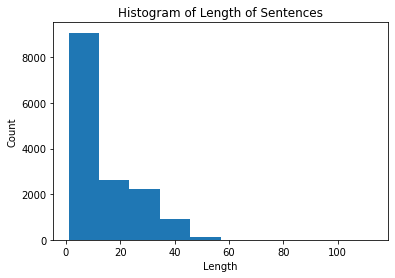

In [10]:
plt.hist(list_len)
plt.title("Histogram of Length of Sentences")
plt.xlabel("Length")
plt.ylabel("Count")
print("Final Length of sentences will be 30")

In [11]:
# Add pad token and unknown token in dictionary
word2idx["PAD"]=0
label2idx["PAD"]=0

In [12]:
#convert a reverse dictionary of labels for mapping it back while creating the dev file output
idx2label={label2idx[k] : k for k in label2idx}

In [13]:
#pad sentences to the maximum length
def padding_sentences(final_length, sentences, labels):
    for i in range(len(sentences)):
        lenn=len(sentences[i])
        if lenn>=final_length:
            sentences[i]=sentences[i][:final_length]
            labels[i]=labels[i][:final_length]
        else:
            sentences[i]+=[0]*(final_length-lenn)
            labels[i]+=[0]*(final_length-lenn)
    return sentences, labels

train_sentences, train_labels = padding_sentences(30, train_sentences, train_labels)

In [14]:
#pad sentences to the maximum length
max_train_sentences=30
for i in range(len(train_sentences)):
    lenn=len(train_sentences[i])
    if lenn>=max_train_sentences:
        train_sentences[i]=train_sentences[i][:max_train_sentences]
        train_labels[i]=train_labels[i][:max_train_sentences]
    else:
        train_sentences[i]+=[0]*(max_train_sentences-lenn)
        train_labels[i]+=[0]*(max_train_sentences-lenn)

In [15]:
def gen_sentences(filename, word2idx, label2idx):
#Same operation for dev data
    val_sentences = []        
    val_labels = []
    temp_sentence=[]
    temp_label=[]
    unk_set=set()

    with open(filename) as f:
        for sentence in f.read().splitlines():
            if sentence=="":
                val_sentences.append(temp_sentence)
                val_labels.append(temp_label)
                temp_sentence=[]
                temp_label=[]
                continue
            _,word,label=sentence.split()

            if word not in word2idx:
                unk_set.add(word)
                temp_sentence.append(word2idx["UNK"])
            else:
                temp_sentence.append(word2idx[word])

            temp_label.append(label2idx[label])

        val_sentences.append(temp_sentence)
        val_labels.append(temp_label)
    return val_sentences, val_labels, unk_set

val_sentences, val_labels, dev_unk_set= gen_sentences("data/dev", word2idx, label2idx)

In [16]:
#padding of dev data
padded_val_sentences= copy.deepcopy(val_sentences)
padded_val_labels = copy.deepcopy(val_labels)
padded_val_sentences, padded_val_labels = padding_sentences(30, padded_val_sentences, padded_val_labels)

### Model 

In [17]:
class myDataset(data.Dataset):
    def __init__(self, features, labels):
        self.features=features
        self.labels=labels
        self.len = len(features)
    def __len__(self):
        return self.len
    def __getitem__(self, index):
        row=self.features[index]
        row_label=self.labels[index]
        return torch.tensor(row),torch.tensor(row_label)

In [18]:
training_set=myDataset(train_sentences, train_labels)
training_generator = data.DataLoader(training_set, batch_size=32, shuffle=True)

In [19]:
padded_val_set=myDataset(padded_val_sentences, padded_val_labels)
padded_val_generator = data.DataLoader(padded_val_set, batch_size=32, shuffle=False)

In [19]:
class Model_LSTM(nn.Module):
    
    def __init__(self, output_size, hidden_dim, embed_size, dropout_rate,  n_layers):
        
        super(Model_LSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        self.embedding=nn.Embedding(len(word2idx),embed_size, padding_idx=0)
        
        self.dropout = nn.Dropout(dropout_rate)
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_dim, batch_first=True, bidirectional=True)   
        
        #dense layer
        self.fc = nn.Linear(2*hidden_dim, output_size)
        self.elu=nn.ELU()
        self.fc1 = nn.Linear(output_size, len(label2idx))
        

        
    def forward(self, x):
        
        s=self.embedding(x)
        s=self.dropout(s)
        s, _ = self.lstm(s)
        s=self.dropout(s)

        s = self.fc(s)          

        s=self.elu(s)

        s=self.fc1(s)

        
        
        
        return s

    
    def init_weights(self):
    # to initialize all parameters from normal distribution
    # helps with converging during training
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)


In [20]:
# Instantiate the model with hyperparameters
model = Model_LSTM(output_size=128, hidden_dim=256, embed_size=100, dropout_rate=0.33,  n_layers=1)
model.init_weights()

In [21]:
# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [20]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
#     epoch_loss = 0
#     epoch_acc = 0
    running_loss = 0.0
#     running_corrects = 0
    
    #set the model in training phase
    model.train()  
    for x_input, y_label in iterator:
        optimizer.zero_grad()   
        
        output= model(x_input)
        output=output.view(-1, output.shape[-1])
        y_label=y_label.long().view(-1)
#         _, preds = torch.max(output, 1)

        #compute the loss
        loss = criterion(output, y_label)  
#         loss = loss_fn(output, y_label)
        
        #compute the binary accuracy
#         acc = binary_accuracy(output, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()     
        
        #clip gradient, to prevent from exploding
#         nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        
        #update the weights
        optimizer.step()      

        #loss and accuracy
        running_loss += loss.item()
#         running_corrects += torch.sum(preds == y_label).item()

    epoch_loss = running_loss / len(iterator)
#     epochs_acc = running_corrects / len(train_sentences)
        

        

    return epoch_loss


In [21]:
def evaluate(model, iterator, criterion):

    model.train(False)

    running_loss = 0
#     running_corrects = 0

    for x_input, y_label in iterator:

        output= model(x_input)
        output=output.view(-1, output.shape[-1])
        y_label=y_label.long().view(-1)
#         _, preds = torch.max(output, 1)

        loss = criterion(output, y_label)  

        running_loss += loss.item()
#         running_corrects += torch.sum(preds == y_label).item()

    epoch_loss = running_loss / len(iterator)
#     epochs_acc = running_corrects / len(val_sentences)

    return epoch_loss
# , epochs_acc

In [24]:
N_EPOCHS = 15
# best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
#     train_loss, train_acc = train(model, training_generator, optimizer, criterion)
    train_loss= train(model, training_generator, optimizer, criterion)
    
#     #evaluate the model
#     valid_loss, valid_acc = evaluate(model, val_generator, criterion)
    valid_loss = evaluate(model, padded_val_generator, criterion)
    
#     #save the best model
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'saved_weights.pt')
    
#     print(f'Epoch: {epoch+1}\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'Epoch: {epoch+1}\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 1	Train Loss: 0.636 | Val. Loss: 0.465
Epoch: 2	Train Loss: 0.346 | Val. Loss: 0.276
Epoch: 3	Train Loss: 0.228 | Val. Loss: 0.211
Epoch: 4	Train Loss: 0.171 | Val. Loss: 0.167
Epoch: 5	Train Loss: 0.138 | Val. Loss: 0.174
Epoch: 6	Train Loss: 0.115 | Val. Loss: 0.175
Epoch: 7	Train Loss: 0.099 | Val. Loss: 0.138
Epoch: 8	Train Loss: 0.086 | Val. Loss: 0.152
Epoch: 9	Train Loss: 0.076 | Val. Loss: 0.131
Epoch: 10	Train Loss: 0.069 | Val. Loss: 0.143
Epoch: 11	Train Loss: 0.064 | Val. Loss: 0.140
Epoch: 12	Train Loss: 0.059 | Val. Loss: 0.136
Epoch: 13	Train Loss: 0.055 | Val. Loss: 0.145
Epoch: 14	Train Loss: 0.050 | Val. Loss: 0.145
Epoch: 15	Train Loss: 0.047 | Val. Loss: 0.133


In [444]:
# save the model to disk
filename = 'hw4_task1.pt'
torch.save(model, filename)
 

task1_model = torch.load(filename)

### Dev Evaluation 

In [22]:
val_set=myDataset(val_sentences, val_labels)
val_generator = data.DataLoader(val_set, batch_size=1, shuffle=False)

In [28]:
y_pred=[]
for test_batch in val_generator:
    pred=task1_model(test_batch[0]).squeeze().topk(1)[1].T[0].numpy()
    y_pred.append(pred.reshape(-1))

In [66]:
def write_out(in_filename, out_filename, y_pred, idx2label):
    open(out_filename, 'w').close()
    f1 = open(out_filename, "a")

    i=0
    j=0
    with open(in_filename) as f:
        for sentence in f.read().splitlines():
            if sentence=="":
                i+=1
                j=0
                f1.write("\n")
                continue
    #         _,word,label=sentence.split()

            f1.write(f'{sentence} {idx2label[y_pred[i][j]]}\n')
            j+=1 


    f1.close()


In [67]:
write_out("data/dev", "val_task1_final.txt", y_pred, idx2label)

### Dev Data output

In [68]:
def write_out_dev(in_filename, out_filename, y_pred, idx2label):
    open(out_filename, 'w').close()
    f1 = open(out_filename, "a")

    i=0
    j=0
    with open(in_filename) as f:
        for sentence in f.read().splitlines():
            if sentence=="":
                i+=1
                j=0
                f1.write("\n")
                continue
            idx,word,label=sentence.split()

            f1.write(f'{idx} {word} {idx2label[y_pred[i][j]]}\n')
            j+=1 


    f1.close()


In [ ]:
write_out_dev("data/dev", "dev_task1_final.txt", y_pred, idx2label)

### Test Data output

In [24]:
#Same operation for test data
test_sentences = []        

temp_sentence=[]

test_unk_set=set()

word_idx=1
label_idx=1
with open("data/test") as f:
    for sentence in f.read().splitlines():
        if sentence=="":
            test_sentences.append(temp_sentence)

            temp_sentence=[]
 
            continue
        _,word=sentence.split()
        
        if word not in word2idx:
            test_unk_set.add(word)
            temp_sentence.append(word2idx["UNK"])
        else:
            temp_sentence.append(word2idx[word])
        

            
    test_sentences.append(temp_sentence)

            
            

In [392]:
import numpy as np
y_pred=[]
for test_sentence in test_sentences:
    pred=task1_model(torch.tensor(test_sentence).view(1,len(test_sentence))).squeeze().topk(1)[1].T[0].numpy()
    y_pred.append(pred.reshape(-1))

In [393]:
write_out("data/test", "test_task1_final.txt", y_pred, idx2label)

## Task 2 - Using GloVe word embeddings

### Data Preprocessing

In [25]:
word2idx_new=copy.deepcopy(word2idx)

In [26]:
embeddings_dict = {}
with open("glove.6B.100d.txt", 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float64")
        embeddings_dict[word] = vector

In [27]:
# Adding 0 or 1 as the first element of the embedding deciding on whether the first letter is uppercase or lowercase.
# This will help in providing case sensitivity as Glove embeddings are case insensitive
glove_emb={}
for word,idx in word2idx_new.items():
    if word=='PAD' or word=='UNK':
        pass
    if word in embeddings_dict:
        glove_emb[idx]=np.append(embeddings_dict[word],0.0)
    elif word.lower() in embeddings_dict:
        glove_emb[idx]=np.append(embeddings_dict[word.lower()],1.0)
    else:
        glove_emb[idx]=np.random.normal(scale=0.6, size=(101, ))

In [28]:
val_arr=np.array(list(glove_emb.values()))
meann=np.mean(val_arr,axis=0)
glove_emb[word2idx_new['PAD']]=np.zeros((101,))
glove_emb[word2idx_new['UNK']]=meann

In [29]:
l=len(glove_emb)

for word in test_unk_set.union(dev_unk_set):
    if word in embeddings_dict:
        glove_emb[l]=np.append(embeddings_dict[word],0.0)
    elif word.lower() in embeddings_dict:
        glove_emb[l]=np.append(embeddings_dict[word.lower()],1.0)
    else:
        continue
    word2idx_new[word]=l
    l+=1

In [30]:
emb_matrix=[]
for i in range(len(glove_emb)):
    emb_matrix.append(glove_emb[i])
emb_matrix=np.array(emb_matrix, dtype='float64')

In [31]:
train_sentences, train_labels, _= gen_sentences("data/train", word2idx_new, label2idx)
train_sentences, train_labels = padding_sentences(30, train_sentences, train_labels)

In [32]:
val_sentences, val_labels, _= gen_sentences("data/dev", word2idx_new, label2idx)
padded_val_sentences= copy.deepcopy(val_sentences)
padded_val_labels = copy.deepcopy(val_labels)
padded_val_sentences, padded_val_labels = padding_sentences(30, padded_val_sentences, padded_val_labels)

### Model - Task 2

In [33]:
training_set=myDataset(train_sentences, train_labels)
training_generator = data.DataLoader(training_set, batch_size=32, shuffle=True)

In [34]:
padded_val_set=myDataset(padded_val_sentences, padded_val_labels)
padded_val_generator = data.DataLoader(padded_val_set, batch_size=32, shuffle=False)

In [85]:
import torch.nn as nn

class Model_Glove_LSTM(nn.Module):
    
    def __init__(self, output_size, hidden_dim, embed_size, dropout_rate,  n_layers):
        
        super(Model_Glove_LSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers



        self.embedding = nn.Embedding(len(word2idx_new),embed_size, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(emb_matrix).float())

        
        self.dropout = nn.Dropout(dropout_rate)
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_dim, batch_first=True, bidirectional=True)   
        
        #dense layer
        self.fc = nn.Linear(2*hidden_dim, output_size)
        self.elu=nn.ELU()
        self.fc1 = nn.Linear(output_size, len(label2idx))
        

        
    def forward(self, x):
        
        s=self.embedding(x)
        s=self.dropout(s)
        s, _ = self.lstm(s)
        s=self.dropout(s)

        s = self.fc(s)          

        s=self.elu(s)

        s=self.fc1(s)

        
        
        
        return s

    
    def init_weights(self):
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)


In [89]:
# Instantiate the model with hyperparameters
model = Model_Glove_LSTM(output_size=128, hidden_dim=256, embed_size=101, dropout_rate=0.33,  n_layers=1)
# model.init_weights()

In [90]:
# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [91]:
N_EPOCHS = 15
# best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    train_loss= train(model, training_generator, optimizer, criterion)

    valid_loss = evaluate(model, padded_val_generator, criterion)
    
    print(f'Epoch: {epoch+1}\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 1	Train Loss: 0.390 | Val. Loss: 0.201
Epoch: 2	Train Loss: 0.219 | Val. Loss: 0.131
Epoch: 3	Train Loss: 0.179 | Val. Loss: 0.118
Epoch: 4	Train Loss: 0.159 | Val. Loss: 0.099
Epoch: 5	Train Loss: 0.142 | Val. Loss: 0.094
Epoch: 6	Train Loss: 0.134 | Val. Loss: 0.086
Epoch: 7	Train Loss: 0.125 | Val. Loss: 0.083
Epoch: 8	Train Loss: 0.117 | Val. Loss: 0.076
Epoch: 9	Train Loss: 0.109 | Val. Loss: 0.070
Epoch: 10	Train Loss: 0.106 | Val. Loss: 0.067
Epoch: 11	Train Loss: 0.098 | Val. Loss: 0.069
Epoch: 12	Train Loss: 0.093 | Val. Loss: 0.065
Epoch: 13	Train Loss: 0.090 | Val. Loss: 0.066
Epoch: 14	Train Loss: 0.087 | Val. Loss: 0.060
Epoch: 15	Train Loss: 0.083 | Val. Loss: 0.058


In [443]:
# save the model to disk
filename = 'hw4_task2.pt'
torch.save(model, filename)
 
task2_model = torch.load(filename)


### Dev Evaluation 

In [93]:
val_set=myDataset(val_sentences, val_labels)
val_generator = data.DataLoader(val_set, batch_size=1, shuffle=False)

In [94]:
y_pred=[]
for test_batch in val_generator:
    pred=task2_model(test_batch[0]).squeeze().topk(1)[1].T[0].numpy()
    y_pred.append(pred.reshape(-1))

In [99]:
write_out("data/dev", "val_task2_final.txt", y_pred, idx2label)

In [ ]:
write_out_dev("data/dev", "dev_task2_final.txt", y_pred, idx2label)

### Test Data output

In [394]:
#Same operation for test data
test_sentences = []        

temp_sentence=[]

test_unk_set=set()

word_idx=1
label_idx=1
with open("data/test") as f:
    for sentence in f.read().splitlines():
        if sentence=="":
            test_sentences.append(temp_sentence)

            temp_sentence=[]
 
            continue
        _,word=sentence.split()
        
        if word not in word2idx_new:
            test_unk_set.add(word)
            temp_sentence.append(word2idx_new["UNK"])
        else:
            temp_sentence.append(word2idx_new[word])
        

            
    test_sentences.append(temp_sentence)

            
            

In [395]:
import numpy as np
y_pred=[]
for test_sentence in test_sentences:
    pred=task2_model(torch.tensor(test_sentence).view(1,len(test_sentence))).squeeze().topk(1)[1].T[0].numpy()
    y_pred.append(pred.reshape(-1))

In [397]:
write_out("data/test", "test_task2_final.txt", y_pred, idx2label)